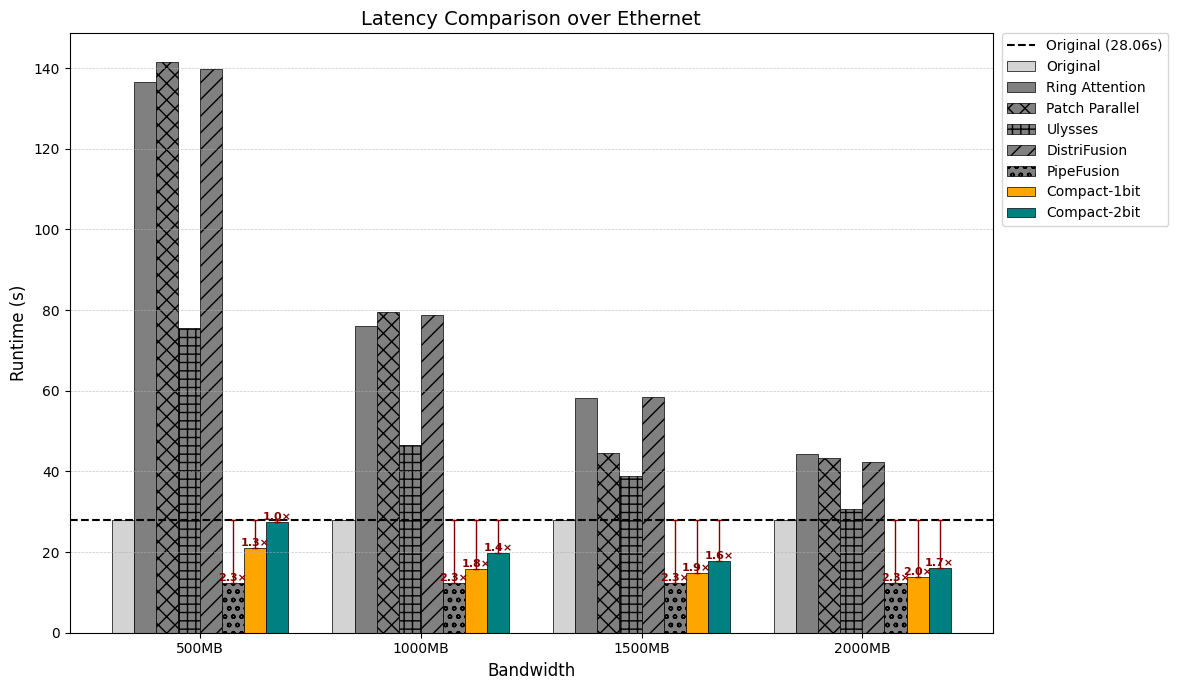

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

LATENCY_DATA_PATH = 'latency_data/latency_eth.csv'

bandwidths = ['500MB', '1000MB', '1500MB', '2000MB']
methods = [
    'Original', 
    'Ring Attention', 
    'Patch Parallel', 
    'Ulysses',
    'DistriFusion', 
    'PipeFusion',
    'Compact-1bit', 
    'Compact-2bit', 
]
method_styles = {
    'Original':      {'color': 'lightgray', 'hatch': None},
    'Ring Attention':{'color': 'gray',      'hatch': None},
    'Compact-1bit':  {'color': 'orange',       'hatch': ''},
    'Compact-2bit':  {'color': 'teal',  'hatch': ''},
    'DistriFusion':  {'color': 'gray',       'hatch': '//'},
    'Patch Parallel':{'color': 'gray',       'hatch': 'xx'},
    'Ulysses':       {'color': 'gray',       'hatch': '++'},
    'PipeFusion':    {'color': 'gray',       'hatch': 'oo'},
}
# Load data using pandas
data_df = pd.read_csv(LATENCY_DATA_PATH, index_col=0)
# Ensure the DataFrame columns and rows are in the desired order
data_df = data_df.loc[methods, bandwidths]

x = np.arange(len(bandwidths))  # the label locations
num_methods = len(methods)
# Calculate width dynamically based on the number of methods to avoid overlap
total_width = 0.8 # Total width allocated for bars at each x tick
width = total_width / num_methods # Width of a single bar
gap = (1 - total_width) / 2 # Gap on either side of the group of bars

fig, ax = plt.subplots(figsize=(14, 7)) # Increased figure size for clarity

# Get the baseline latency (Original method)
# Assuming 'Original' latency is constant across bandwidths as per data_eth.csv
# If it could vary, use data_df.loc['Original'].values
original_latency = data_df.loc['Original', bandwidths[0]]

# Draw the horizontal baseline reference line
ax.axhline(original_latency, color='black', linestyle='--', linewidth=1.5, label=f'Original ({original_latency:.2f}s)')

# Plot bars for each method
for i, method in enumerate(methods):
    method_latencies = data_df.loc[method].values
    # Calculate the position for each bar group
    # Start position for the group: x - total_width / 2
    # Position for this method's bar: start_pos + i * width + width / 2
    # Simplified: x + (i - num_methods / 2 + 0.5) * width
    position = x - total_width / 2 + i * width + width / 2
    style = method_styles.get(method, {'color': 'gray', 'hatch': None}) # Default style if method not in dict
    bars = ax.bar(position, method_latencies, width, label=method,
                  color=style['color'], hatch=style['hatch'], edgecolor='black', linewidth=0.5)

    # Add speedup annotations and lines for methods faster than Original
    if method != 'Original':
        original_latencies_values = data_df.loc['Original'].values
        for j, bar in enumerate(bars):
            method_latency = method_latencies[j]
            # Use the specific original latency for this bandwidth if it varies
            # Here, it's constant, so original_latency could be used directly
            orig_latency_bw = original_latencies_values[j]

            # Only annotate if the method is faster (latency is lower)
            if method_latency < orig_latency_bw:
                speedup = orig_latency_bw / method_latency
                bar_x = bar.get_x() + bar.get_width() / 2
                bar_y = bar.get_height()

                # Draw vertical line from baseline (Original latency) down to the bar top
                ax.plot([bar_x, bar_x], [orig_latency_bw, bar_y], color='maroon', linestyle='-', linewidth=1.0, marker='_', markersize=4)

                # Add speedup text annotation slightly above the bar
                ax.text(bar_x, bar_y, f"{speedup:.1f}×",
                        ha='center', va='bottom', fontsize=8, color='maroon', fontweight='bold', rotation=0) # Place text right above bar

# Configure axes, labels, title, legend
ax.set_ylabel('Runtime (s)', fontsize=12)
ax.set_xlabel('Bandwidth', fontsize=12)
ax.set_title('Latency Comparison over Ethernet', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(bandwidths, fontsize=10)
ax.tick_params(axis='y', labelsize=10)

# Improve legend placement (outside the plot area)
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0., fontsize=10)

ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_ylim(bottom=0) # Ensure y-axis starts at 0

# Adjust layout to prevent labels/legend from overlapping
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust right margin to fit legend

plt.show()
